In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os 
from PIL import Image, ImageOps
import copy
from matplotlib.patches import Circle
import pickle
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D

In [2]:
path = 'C:/Users/Onur/Desktop/amme dataset/annotated_frames'
l_path = 'C:/Users/Onur/Desktop/amme dataset/projections_2d'
b_path = 'C:/Users/Onur/Desktop/amme dataset/bounding_boxes'

C:/Users/Onur/Desktop/amme dataset/annotated_frames\data_1
C:/Users/Onur/Desktop/amme dataset/annotated_frames\data_2
(480, 640, 3)


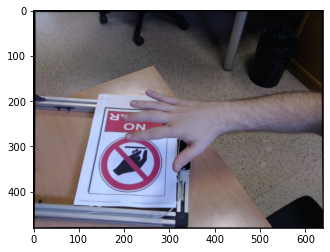

In [3]:
images = []

for folder in glob.glob(os.path.join(path,'data_'+'[1-2]')):
    print(folder)
    for file_name in glob.glob(os.path.join(folder,'*.jpg')):
        image = Image.open(file_name)
        images.append(copy.copy(image))
        image.close()
        

print(np.shape(images[0]))
plt.imshow(images[0])

In [4]:
labels = []

for folder in glob.glob(os.path.join(l_path,'data_'+'[1-2]')):
    print(folder)
    for file_name in glob.glob(os.path.join(folder,'*txt')):        
        label = pd.read_csv(file_name,delimiter=' ',header=None, usecols=[1,2]).values
        labels.append(label)

C:/Users/Onur/Desktop/amme dataset/projections_2d\data_1
C:/Users/Onur/Desktop/amme dataset/projections_2d\data_2


In [5]:
blabels = []

for folder in glob.glob(os.path.join(b_path,'data_'+'[1-2]')):
    print(folder)
    for file_name in glob.glob(os.path.join(folder,'*txt')):
        label = pd.read_csv(file_name,delimiter=' ',header=None, usecols=[1]).values
        blabels.append(label)

C:/Users/Onur/Desktop/amme dataset/bounding_boxes\data_1
C:/Users/Onur/Desktop/amme dataset/bounding_boxes\data_2


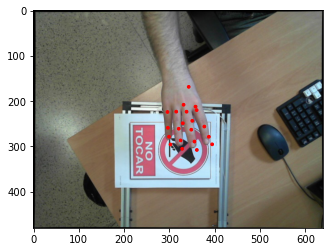

In [6]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(images[22])

for xx,yy in labels[22]:
    circ = Circle((xx,yy),3, color = 'red')
    ax.add_patch(circ)

In [8]:
max_height,max_width = 0,0
for i,_ in enumerate(blabels):
    t, l, b, r = blabels[i]
    t,l,b,r = int(t),int(l),int(b),int(r)
    
    if(b-t>max_height):
        max_height=b-t
    if(r-l>max_width):
        max_width=r-l
        
print(max_height,max_width)

290 334


In [7]:
crop = []

for i,_ in enumerate(images):
    t, l, b, r = [int(j) for j in blabels[i]]
    crop.append(images[i].crop((l,t,r,b)))

In [9]:
padded =[]

for i,item in enumerate(crop):
    t, l, b, r = [int(j) for j in blabels[i]]
    r_pad = max_width-item.size[0]
    b_pad = max_height-item.size[1]
    padded.append(ImageOps.expand(crop[i], (0,0,r_pad,b_pad)))

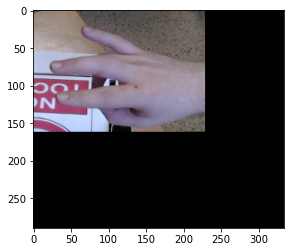

In [36]:
plt.imshow(padded[4])

In [11]:
labels = np.array(labels)
for i,item in enumerate(labels):
    t, l, b, r = [int(j) for j in blabels[i]]
    labels[i,:,0] = labels[i,:,0] - l
    labels[i,:,1] = labels[i,:,1] - t

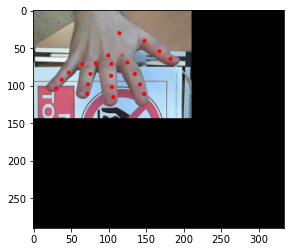

In [20]:
sample_n = random.randint(1,8000)
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(padded[sample_n])

for xx,yy in labels[sample_n]:
    circ = Circle((xx,yy),2, color = 'red')
    ax.add_patch(circ)

In [39]:
padded_pickle =  []
labels_pickle = []
blabels_pickle =  []


for i,item in enumerate(padded):
    padded_pickle.append(np.array(padded[i]))
padded_pickle=np.array(padded_pickle)    

for i,item in enumerate(labels):
    labels_pickle.append(np.array(labels[i]))
labels_pickle=np.array(labels_pickle) 


for i,item in enumerate(blabels):
    blabels_pickle.append(np.array(blabels[i]))
blabels_pickle=np.array(blabels_pickle)

In [40]:
print(padded_pickle.shape)
print(labels_pickle.shape)
print(blabels_pickle.shape)

(9432, 290, 334, 3)
(9432, 21, 2)
(9432, 4, 1)


In [41]:
data = {'padded':padded_pickle,'labels':labels_pickle,'blabels':blabels_pickle}

with open('data.pickle','wb') as file_to_dump:
    pickle.dump(data,file_to_dump)

-------------------------------- MODEL-------------------------------------------

In [3]:
with open('data.pickle','rb') as pickle_file_to_load:
    data = pickle.load(pickle_file_to_load)

In [4]:
inputs = data['padded']
labels = data['labels']
blabels = data['blabels']

blabels = np.reshape(blabels,(blabels.shape[0],blabels.shape[1]*blabels.shape[2]))
labels = labels.reshape((labels.shape[0],labels.shape[1]*labels.shape[2]))

print(blabels.shape)
print(labels.shape)

(9432, 4)
(9432, 42)


In [5]:
initializer = tf.keras.initializers.GlorotUniform()

In [15]:
model = Sequential([
    Conv2D(32, kernel_size = [4,4],strides=[2,2], padding = 'VALID', kernel_initializer = initializer , activation='relu', input_shape=inputs.shape[1:4]),
    Conv2D(64, kernel_size = [4,4],strides=[2,2], padding = 'VALID', kernel_initializer = initializer , activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(64, kernel_size = [4,4],strides=[2,2], padding = 'VALID', kernel_initializer = initializer , activation='relu'),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(128, kernel_size = [4,4], strides=[2,2],padding = 'VALID', kernel_initializer = initializer , activation='relu'),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(128, kernel_size = [4,4], strides=[2,2],padding = 'VALID', kernel_initializer = initializer , activation='relu'),
    Dropout(0.25),
    
    Flatten(),
    BatchNormalization(),
    Dense(128,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(labels.shape[1],activation='relu')
])

In [16]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr=0.003))

In [17]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 144, 166, 32)      1568      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 71, 82, 64)        32832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 41, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 35, 41, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 35, 41, 64)        256       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 19, 64)        65600     
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 19, 64)       

In [18]:
history = model.fit(inputs[:8600],labels[:8600],epochs=10,batch_size=64,verbose=1,validation_data=(inputs[8600:],labels[8600:]))

Epoch 1/10
135/135 [==============================] - 393s 3s/step - loss: 4860.2920 - val_loss: 1567.7444
Epoch 2/10
135/135 [==============================] - 370s 3s/step - loss: 599.4905 - val_loss: 1063.2783
Epoch 3/10
135/135 [==============================] - 357s 3s/step - loss: 459.1383 - val_loss: 506.3200
Epoch 4/10
135/135 [==============================] - 378s 3s/step - loss: 407.7107 - val_loss: 739.2024
Epoch 5/10
135/135 [==============================] - 385s 3s/step - loss: 379.9055 - val_loss: 431.6120
Epoch 6/10
135/135 [==============================] - 385s 3s/step - loss: 343.6988 - val_loss: 536.1500
Epoch 7/10
135/135 [==============================] - 390s 3s/step - loss: 328.5896 - val_loss: 417.7294
Epoch 8/10
135/135 [==============================] - 350s 3s/step - loss: 299.4964 - val_loss: 379.6311
Epoch 9/10
135/135 [==============================] - 334s 2s/step - loss: 289.9619 - val_loss: 740.1425
Epoch 10/10
135/135 [==============================]

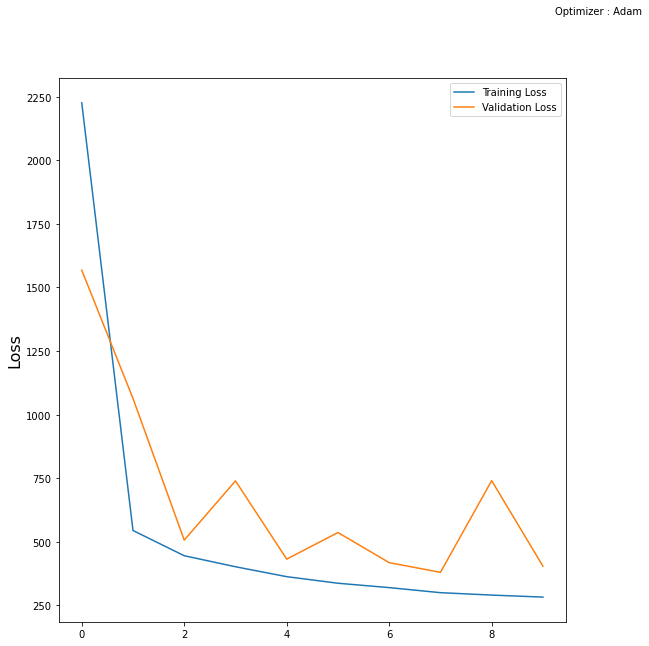

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [19]:
model.save('inzva.h5')

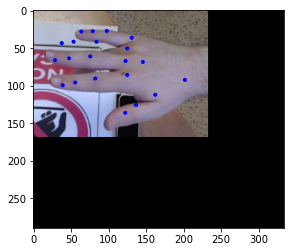

In [39]:
sample_n = random.randint(0,9300)

preds = model.predict(inputs[sample_n:sample_n+1])

fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.imshow(inputs[sample_n])

for xx, yy in preds[0].reshape((21,2)):
    circ = Circle((xx,yy),2,color='blue')
    ax.add_patch(circ)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('inzva.h5')